# ![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Co-integrated Pairs Trading & Momentum Strategy 

Here I've used a pairs trading strategy based on the co-integration of ETFs, combined with momentum indicators.

The principle is as follows:

-Let's say you have a pair of securities X and Y that have some underlying economic link.(This is especially relevant for sectoral ETFs that consist of a diversified portfolio of assets of the same industry).

-These time series may not be independently stationary, but they may have a relationship where the difference tends to be stationary. In this case the time-series are considered co-integrated.

-You expect the spread between these two to remain constant with time, if the stationary test generates statistically significant results.

-However, from time to time, there might be a divergence in the spread between these two pairs. When there is a temporary divergence between the two securities, the pairs trade consists of, betting that the "spread" between the two would eventually converge.

Technical Implementation of the strategy:

-After some data cleaning and pre-processing I run multiple OLS models between pairs to observe whether linear regression models are a good fit to describe the evolution of log prices of ETFs.

-The aim is to use the resulting beta of the OLS regressions as the hedge ratio to create the spread series. Based on initial visual checks most of the spreads seem stationary but we'll run a robust statistical method to check their stationarity (Augmented Dickey-Fuller Test)

-ADF tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is stationarity. The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence. The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series will provide no relevant information in predicting the change. In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

-I've used this intuition to filter the pairs whose spread series, suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

-I've used this approach to generate trading signals. If the sample is out of the range defined by +/- 1.96 standard deviations away from the mean, then we think there is a price divergence between these two asset prices which means the pairs trading opportunity is present.

-I've added an extra filter based on momentum indicators to the buy/sell trading signals generated above. This combination would ensure that our trading signal is in line with the price trend. Therefore, this algorithm simultaneously checks whether: i. the instrument for which pairs trading strategy has indicated a buy signal, has a positive momentum (on average) -> if so, final insight is a buy ii. the instrument for which pairs trading strategy has indicated a sell signal, has a negative momentum (on average) -> if so, final insight is a sell

If both conditions are met, pairs trading is executed

Why pairs trading makes sense for ETFs:

-ETFs are designed to track a well-diversified portfolio of assets. For this reason, ETFs should have much less idiosyncratic risk than individual common stocks. It has been shown that pairs trades are less profitable when the original price deviation is associated with a fundamental change in the value of the individual stocks. But the strategy is signficantly profitable when the cause of the price divergence is related to temporary liquidity factors, or to news that affects systematically the underlying assets in a basket (which is the case for ETFs especially the ones that cover a given sector).

Source: Engelberg, Gao, and Jagannathan (2009) This study also extends the analysis to test for the optimal time to exit from a pairs trade, and finds that it is more profitable to close out positions after 10 days if the spread of the pairs doesn't converge*

-As prices in a pair of ETFs were closely cointegrated in the past, there is a high probability those two securities share common sources of fundamental return correlations. A temporary shock could move one ETF out of the common price band. This presents a statistical arbitrage opportunity. The universe of pairs is continuously updated, which ensures that pairs which no longer move in synchronicity are removed from trading, and only pairs with a high probability of convergence remain.

-ETFs can be sold short more easily than stocks because the uptick rule doesn’t apply to them. For this reason, it may be easier to employ a pairs trading strategy on ETFs than on stocks.

In [153]:
from clr import AddReference
AddReference("System")
AddReference('System.Memory')
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Research")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd

# Create an instance
qb = QuantBook()

In [154]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
plt.style.use('seaborn-whitegrid')
from sklearn import linear_model
import statsmodels
from statsmodels.tsa.stattools import coint

In [155]:
#Create a list of tickers for our ETF universe
#This is important when working in the research environment because
#Quantconnect does not have the option to import the Selected Universe in this environment.
#Source: https://github.com/QuantConnect/Lean/tree/master/Algorithm.Framework/Selection

tickers_energy=["XLE","IYE","VDE","USO","XES","XOP","UNG","ICLN","ERX","ERY","SCO","UCO","AMJ","BNO","AMLP","OIH","DGAZ","UGAZ","TAN"]
tickers_metals=["GLD", "IAU", "SLV", "GDX", "AGQ","GDXJ", "PPLT", "NUGT", "USLV", "UGLD", "JNUG",
"DUST", "JDST"]
#tickers_treasuries=["IEF", "SHY", "TLT","SHV", "IEI", "TLH", "EDV", "BIL", "SPTL","VGSH","VGIT","VGLT",
               # "TMF", "SCHO", "SCHR", "SPTS", "GOVT","SHV", "TBT", "TMV"]
tickers_treasuries=["IEF", "SHY", "TLT","IEI", "TLH", "EDV", "BIL", "SPTL","VGSH","VGIT","VGLT",
                "TMF", "SCHO", "SCHR", "SPTS", "GOVT","SHV", "TBT", "TMV"]
tickers_tech=["XLK","QQQ","SOXX","IGV","VGT","QTEC","FDN","FXL","TECL","TECS","SOXL","SOXS","SKYY","SMH","KWEB","FTEC"]
tickers_vol=["SQQQ","TQQQ","TVIX","VIXY","SPLV","SVXY","UVXY","EEMV","EFAV","USMV"]

tickers_all= [*tickers_energy, *tickers_metals,*tickers_treasuries,*tickers_tech,*tickers_vol] 

In [156]:
#Set start and end date
start = datetime(2019,1,1)
end = datetime(2019,4,1)

In [157]:
#Add Benchmark
spy = qb.AddEquity("SPY")
benchmark=qb.History(spy.Symbol,start ,end, Resolution.Daily)["close"]
benchmark.head()

symbol            time      
SPY R735QTJ8XC9X  2019-01-03    242.057531
                  2019-01-04    236.281356
                  2019-01-05    244.195780
                  2019-01-08    246.121172
                  2019-01-09    248.433577
Name: close, dtype: float64

In [158]:
#I've created separate dataframes to save the close price for different sectors 
price_energy=pd.DataFrame(columns=tickers_energy)
for i in range(len(tickers_energy)):
    qb.AddEquity(tickers_energy[i])
    this_column = price_energy.columns[i]
    price_energy[this_column]=qb.History([tickers_energy[i]],start ,end, Resolution.Daily).loc[tickers_energy[i]]['close']
price_energy.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,SCO,UCO,AMJ,BNO,AMLP,OIH,DGAZ,UGAZ,TAN
time,,,,,,,,,,,,,,,,,,,
2019-01-03,52.055908,28.780792,73.232584,78.80,89.283876,105.011014,24.49,8.162606,155.458464,59.739713,28.17,344.25,19.678799,15.56,37.525730,281.113125,122.00,391.7,18.734383
2019-01-04,51.539621,28.500401,72.545042,79.60,89.961002,104.279900,24.21,8.093930,150.524810,61.750089,27.63,351.50,19.896774,15.78,37.736786,283.460625,126.30,379.4,18.534975
2019-01-05,53.293215,29.549607,75.211592,81.44,95.184544,110.167289,25.09,8.339200,166.293155,55.167092,26.34,367.25,20.803551,16.18,39.847344,297.154375,112.98,418.6,19.392430
2019-01-08,54.085447,30.010895,76.438020,82.32,99.537496,113.938297,24.38,8.407876,173.161575,52.989184,25.83,374.25,21.195906,16.26,40.353879,308.696250,121.63,384.8,19.751364
2019-01-09,54.503817,30.282242,77.088398,84.00,99.730960,114.977248,24.74,8.505984,177.514799,51.648933,24.73,390.25,21.701608,16.56,41.366947,311.826250,116.89,400.8,19.761335


In [159]:
price_metals=pd.DataFrame(columns=tickers_metals)
for i in range(len(tickers_metals)):
    qb.AddEquity(tickers_metals[i])
    this_column = price_metals.columns[i]
    price_metals[this_column]=qb.History([tickers_metals[i]],start ,end, Resolution.Daily).loc[tickers_metals[i]]['close']
price_metals.head()

,GLD,IAU,SLV,GDX,AGQ,GDXJ,PPLT,NUGT,USLV,UGLD,JNUG,DUST,JDST
time,,,,,,,,,,,,,
2019-01-03,121.33,12.30,14.56,20.902193,26.38,30.200321,75.32,86.089273,74.60,95.43,460.128405,564.473245,1218.818136
2019-01-04,122.43,12.41,14.75,21.329174,27.29,31.315532,75.67,91.494648,77.69,98.16,510.153129,530.604850,1090.186848
2019-01-05,121.44,12.32,14.73,21.150438,27.10,31.146259,77.87,88.915937,77.06,95.91,501.237832,545.084816,1102.658703
2019-01-08,121.86,12.35,14.67,20.892263,26.83,30.688226,77.94,85.890911,76.33,96.62,482.416648,564.227822,1148.144292
2019-01-09,121.53,12.32,14.69,20.902193,26.93,30.927200,77.76,85.841320,76.42,95.79,492.322534,563.246129,1127.113321


In [160]:
price_treasuries=pd.DataFrame(columns=tickers_treasuries)
for i in range(len(tickers_treasuries)):
    qb.AddEquity(tickers_treasuries[i])
    this_column = price_treasuries.columns[i]
    price_treasuries[this_column]=qb.History([tickers_treasuries[i]],start ,end, Resolution.Daily).loc[tickers_treasuries[i]]['close']
price_treasuries.head()

,IEF,SHY,TLT,IEI,TLH,EDV,BIL,SPTL,VGSH,VGIT,VGLT,TMF,SCHO,SCHR,SPTS,GOVT,SHV,TBT,TMV
time,,,,,,,,,,,,,,,,,,,
2019-01-03,101.553431,81.349736,118.233883,118.256585,129.884315,109.993815,89.673465,34.001139,58.172299,61.328934,72.282432,19.438328,48.449652,51.279957,28.871386,24.192479,107.492969,33.924458,176.545656
2019-01-04,102.360645,81.515101,119.579320,118.927779,131.087397,111.609532,89.702882,34.407181,58.298129,61.734638,73.099889,20.100100,48.556454,51.589688,28.929929,24.328775,107.531948,33.133246,170.457875
2019-01-05,101.533980,81.340009,118.195166,118.266313,129.699972,110.138075,89.712688,33.991471,58.172299,61.367572,72.243963,19.428450,48.430233,51.289636,28.881143,24.202214,107.561182,33.885386,176.251086
2019-01-08,101.251941,81.281645,117.846707,118.032854,129.263370,109.637972,89.712688,33.914130,58.133582,61.203359,72.051620,19.211152,48.420523,51.183165,28.861629,24.153537,107.561182,34.119820,177.920316
2019-01-09,100.999079,81.233008,117.536966,117.818850,128.904386,109.368686,89.712688,33.836789,58.094865,61.106762,71.878512,19.062994,48.362267,51.096053,28.842115,24.104860,107.551437,34.315181,179.491357


In [161]:
price_tech=pd.DataFrame(columns=tickers_tech)
for i in range(len(tickers_tech)):
    qb.AddEquity(tickers_tech[i])
    this_column = price_tech.columns[i]
    price_tech[this_column]=qb.History([tickers_tech[i]],start ,end, Resolution.Daily).loc[tickers_tech[i]]['close']
price_tech.head()

,XLK,QQQ,SOXX,IGV,VGT,QTEC,FDN,FXL,TECL,TECS,SOXL,SOXS,SKYY,SMH,KWEB,FTEC
time,,,,,,,,,,,,,,,,
2019-01-03,60.592064,153.001693,154.168784,171.552035,163.418260,67.534947,117.47,51.959528,84.484856,272.301383,84.878279,1519.563507,47.942126,86.649316,37.498738,48.321176
2019-01-04,57.534128,148.003058,145.177558,166.155629,155.341817,64.356135,114.08,49.939266,72.045124,313.633722,69.794099,1785.842159,46.830425,81.388289,36.169845,45.912461
2019-01-05,60.084036,154.335321,151.728169,173.778176,162.096660,67.070959,119.80,52.108808,81.186141,272.301383,78.814835,1552.700406,48.795754,85.191204,38.318054,47.929515
2019-01-08,60.621373,156.172764,154.529995,177.236646,163.907742,68.147017,122.54,53.183627,83.312421,264.723788,83.439327,1466.307776,49.599752,86.757689,39.257271,48.468049
2019-01-09,61.129401,157.585421,153.856385,180.049137,165.483872,68.423435,124.75,53.780749,85.547996,257.736654,82.159157,1485.243147,50.373973,86.363605,39.397155,48.938042


In [162]:
price_vol=pd.DataFrame(columns=tickers_vol)
for i in range(len(tickers_vol)):
    qb.AddEquity(tickers_vol[i])
    this_column = price_vol.columns[i]
    price_vol[this_column]=qb.History([tickers_vol[i]],start ,end, Resolution.Daily).loc[tickers_vol[i]]['close']
price_vol.head()

,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
time,,,,,,,,,,
2019-01-03,322.461249,37.542799,66.72,37.46,44.174705,42.99,77.92,53.713163,62.795098,50.108253
2019-01-04,354.316512,33.905435,72.81,39.22,43.732381,41.92,83.30,53.096545,62.672322,49.375055
2019-01-05,307.803920,38.242293,61.35,36.07,44.626645,43.66,73.54,54.329780,64.041744,50.455557
2019-01-08,298.032367,39.461409,58.62,35.31,44.655492,44.11,70.95,54.426127,64.117298,50.619561
2019-01-09,289.628831,40.600584,56.25,34.57,45.136279,44.58,68.80,54.512838,64.249518,51.053692


In [163]:
price_all=pd.DataFrame(columns=tickers_all)
for i in range(len(tickers_all)):
    qb.AddEquity(tickers_all[i])
    this_column = price_all.columns[i]
    price_all[this_column]=qb.History([tickers_all[i]],start ,end, Resolution.Daily).loc[tickers_all[i]]['close']
price_all.index = price_all.index.date
price_all.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,52.055908,28.780792,73.232584,78.80,89.283876,105.011014,24.49,8.162606,155.458464,59.739713,...,322.461249,37.542799,66.72,37.46,44.174705,42.99,77.92,53.713163,62.795098,50.108253
2019-01-04,51.539621,28.500401,72.545042,79.60,89.961002,104.279900,24.21,8.093930,150.524810,61.750089,...,354.316512,33.905435,72.81,39.22,43.732381,41.92,83.30,53.096545,62.672322,49.375055
2019-01-05,53.293215,29.549607,75.211592,81.44,95.184544,110.167289,25.09,8.339200,166.293155,55.167092,...,307.803920,38.242293,61.35,36.07,44.626645,43.66,73.54,54.329780,64.041744,50.455557
2019-01-08,54.085447,30.010895,76.438020,82.32,99.537496,113.938297,24.38,8.407876,173.161575,52.989184,...,298.032367,39.461409,58.62,35.31,44.655492,44.11,70.95,54.426127,64.117298,50.619561
2019-01-09,54.503817,30.282242,77.088398,84.00,99.730960,114.977248,24.74,8.505984,177.514799,51.648933,...,289.628831,40.600584,56.25,34.57,45.136279,44.58,68.80,54.512838,64.249518,51.053692


# Momentum Indicators  

Momentum indicators in this algorithm are used to sense-check the buy/sell trading signals generated by the Pairs Trading strategy. This combination ensures that our trading signal is in line with the price trend.

I will test separately the performance of two different momentum strategies, and will choose the best performing one to later combine it with the Pairs-trading strategy.

**Price vs. EMA comparison**

Intuition: when a change in the long term behaviour of the asset occurs, the actual price timeseries will react faster than the EMA one. Therefore, we will consider the crossing of the two as potential trading signals.

- When the price timeseries p(t) crosses the EMA timeseries from below, we will close any existing short position and go long (buy) one unit of the asset.
- When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.

**Short EMA vs. Long EMA comparison**

Intuition: Similiar to the intuition above, but instead of using noisy price signals we use short EMA 

- If 20EMA > 50EMA the final insight is a buy.
- If 20EMA < 50EMA the final insight is a sell.


## Price vs. EMA comparison

Text(0, 0.5, 'Price')

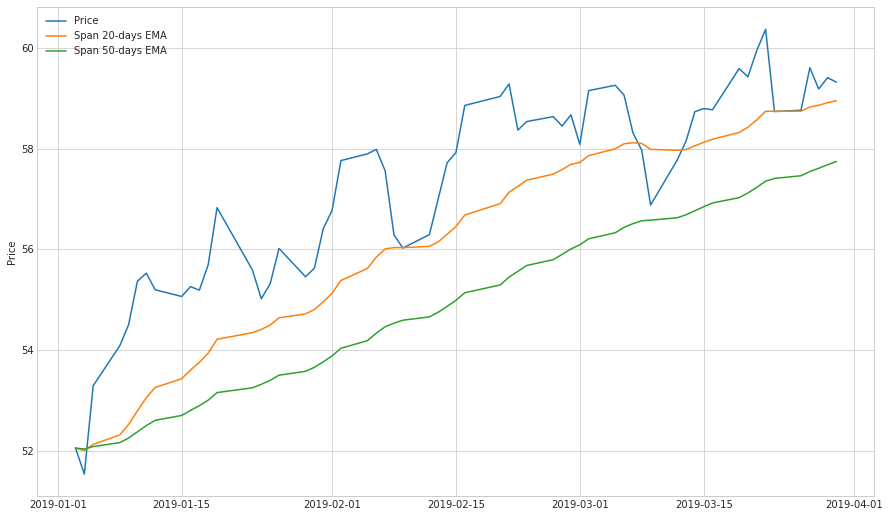

In [164]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = price_all.ewm(span=20, adjust=False).mean()
ema_long = price_all.ewm(span=50, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(price_all.loc[:, price_all.columns[0]], label='Price')

ax.plot(ema_short.loc[:, ema_short.columns[0]], label = 'Span 20-days EMA')
ax.plot(ema_long.loc[:, ema_long.columns[0]], label = 'Span 50-days EMA')


ax.legend(loc='best')
ax.set_ylabel('Price')

In [165]:
### Calculate Returns ###
returns_data = price_all.copy()
returns_data=np.log(price_all).diff()
returns_data.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.009967,-0.009790,-0.009433,0.010101,0.007555,-0.006987,-0.011499,-0.008449,-0.032251,0.033098,...,0.094208,-0.101906,0.087349,0.045913,-0.010064,-0.025204,0.066766,-0.011546,-0.001957,-0.014740
2019-01-05,0.033458,0.036152,0.036098,0.022852,0.056441,0.054921,0.035704,0.029853,0.099624,-0.112729,...,-0.140728,0.120367,-0.171258,-0.083725,0.020242,0.040669,-0.124619,0.022961,0.021615,0.021648
2019-01-08,0.014756,0.015490,0.016175,0.010748,0.044717,0.033657,-0.028706,0.008202,0.040473,-0.040279,...,-0.032261,0.031381,-0.045519,-0.021295,0.000646,0.010254,-0.035854,0.001772,0.001179,0.003245
2019-01-09,0.007706,0.009001,0.008473,0.020203,0.001942,0.009077,0.014658,0.011601,0.024829,-0.025618,...,-0.028602,0.028459,-0.041270,-0.021180,0.010709,0.010599,-0.030772,0.001592,0.002060,0.008540


In [166]:

#design a trading strategy, to take advantage of the fact that a moving average timeseries lags the actual price behaviour.

#Bearing this in mind, it is natural to assume that when a change in the long term behaviour of the asset occurs, 
#the actual price timeseries will react faster than the EMA one. 
#Therefore, we will consider the crossing of the two as potential trading signals.

#When the price timeseries p(t) crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.
#When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.
trading_positions_raw = price_all - ema_short
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/number of instruments
trading1 = trading_positions_raw.apply(np.sign)*1/(len(trading_positions_raw.columns))
trading1.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04,-0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,-0.012987,-0.012987,-0.012987,0.012987,...,0.012987,-0.012987,0.012987,0.012987,-0.012987,-0.012987,0.012987,-0.012987,-0.012987,-0.012987
2019-01-05,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,...,-0.012987,0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987
2019-01-08,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,-0.012987,...,-0.012987,0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987
2019-01-09,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,...,-0.012987,0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987


Text(0, 0.5, 'Price')

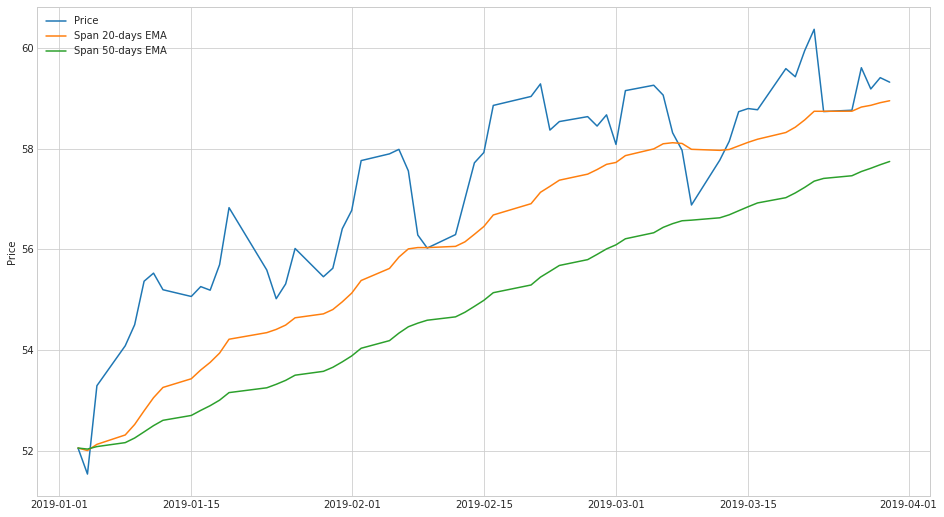

In [167]:
fig, (ax1) =plt.subplots(figsize=(16,9))

ax1.plot(price_all.loc[:, price_all.columns[0]], label='Price')

ax1.plot(ema_short.loc[:, ema_short.columns[0]], label = 'Span 20-days EMA')
ax1.plot(ema_long.loc[:, ema_long.columns[0]], label = 'Span 50-days EMA')


ax1.legend(loc='best')
ax1.set_ylabel('Price')


In [168]:
strategy1_ret = trading1 * returns_data
strategy1_ret.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,0.000129,0.000127,0.000123,0.000131,0.000098,0.000091,0.000149,0.000110,0.000419,0.000430,...,0.001223,0.001323,0.001134,0.000596,0.000131,0.000327,0.000867,0.000150,0.000025,0.000191
2019-01-05,0.000435,0.000470,0.000469,0.000297,0.000733,0.000713,0.000464,0.000388,0.001294,0.001464,...,0.001828,0.001563,0.002224,0.001087,0.000263,0.000528,0.001618,0.000298,0.000281,0.000281
2019-01-08,0.000192,0.000201,0.000210,0.000140,0.000581,0.000437,0.000373,0.000107,0.000526,0.000523,...,0.000419,0.000408,0.000591,0.000277,0.000008,0.000133,0.000466,0.000023,0.000015,0.000042
2019-01-09,0.000100,0.000117,0.000110,0.000262,0.000025,0.000118,0.000190,0.000151,0.000322,0.000333,...,0.000371,0.000370,0.000536,0.000275,0.000139,0.000138,0.000400,0.000021,0.000027,0.000111


In [169]:
benchmark_ret=np.log(benchmark).diff()
benchmark_ret=benchmark_ret.cumsum()
benchmark_cum=np.exp(benchmark_ret)-1

In [170]:
#sum(cum_relative_returns1.loc[cum_relative_returns1.index[1],:])

## Portfolio 1- Returns

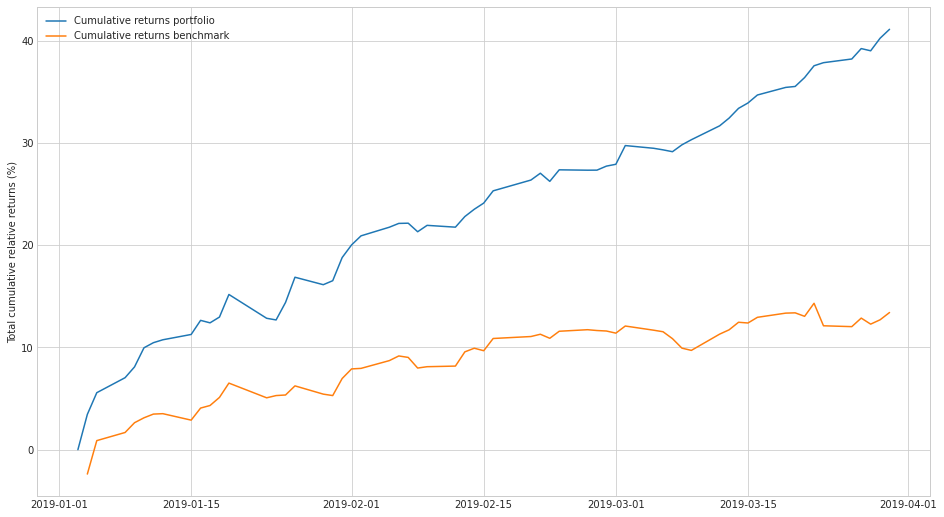

In [171]:
ret1= strategy1_ret.cumsum()
cum_relative_returns1 = np.exp(ret1) - 1
cum_ret1_tot = cum_relative_returns1.sum(axis=1)
#cum_ret1_tot
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_ret1_tot.index, 100*cum_ret1_tot, label='Cumulative returns portfolio')
ax.plot(cum_ret1_tot.index, 100*benchmark_cum, label='Cumulative returns benchmark')
ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')

In [258]:
def print_portfolio_yearly_statistics(portfolio_cumulative_returns, days_per_year = 52*5):

    total_days_in_simulation = price_all.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_returns[-1]
    total_return_benchmark = benchmark_cum[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1
    average_yearly_return_benchmark = (1 + benchmark_cum[-1])**(1/number_of_years) - 1
    print('Holding period in days: ' + '{:5.2f}'.format(round(price_all.shape[0])))    
    print('Total portfolio return for the holding period is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Total bechmark return for the holding period is: ' + '{:5.2f}'.format(100*total_return_benchmark) + '%')

print_portfolio_yearly_statistics(cum_ret1_tot)

Holding period in days: 61.00
Total portfolio return for the holding period is: 41.10%
Total bechmark return for the holding period is: 13.41%


## Short EMA vs. Long EMA comparison

In [173]:
#Compare portfolio returns with the benchmark S&P
### Create a tempdf to save the diff between EMA_short and EMA_long ###
temp_df = ema_long.copy()
temp_df=ema_short-ema_long
### Create momentum signal: 1 indicates upward trend (EMA short>EMA long) and -1 indicates downward trend
#momentum_signal = momentum_signal.apply(func = lambda x: np.log(x.shift(1)/x.shift(20)), axis = 0)
#momentum_signal = momentum_signal.rank(axis = 1).dropna()
temp_df.head()


,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04,-0.028924,-0.015708,-0.038518,0.044818,0.037934,-0.040959,-0.015686,-0.003847,-0.276395,0.112626,...,1.784609,-0.203774,0.341176,0.098599,-0.024780,-0.059944,0.301401,-0.034544,-0.006878,-0.041075
2019-01-05,0.044282,0.029475,0.077530,0.186691,0.363403,0.253415,0.020036,0.006563,0.367753,-0.158686,...,0.723522,-0.137188,-0.005536,0.007471,0.003870,-0.014349,0.015498,0.004645,0.063887,-0.016096
2019-01-08,0.152136,0.094484,0.246826,0.358621,0.888833,0.719624,0.011238,0.019436,1.311110,-0.515952,...,-0.748988,-0.010497,-0.459848,-0.114350,0.030377,0.050549,-0.378188,0.044091,0.129395,0.014866
2019-01-09,0.268761,0.165843,0.429505,0.600855,1.353098,1.180406,0.023717,0.036049,2.370134,-0.899673,...,-2.497002,0.163492,-0.985828,-0.261276,0.080241,0.133106,-0.839447,0.083074,0.193265,0.066047


In [174]:
trading2 = temp_df.apply(np.sign)*1/(len(temp_df.columns))
trading2.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-04,-0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,-0.012987,-0.012987,-0.012987,0.012987,...,0.012987,-0.012987,0.012987,0.012987,-0.012987,-0.012987,0.012987,-0.012987,-0.012987,-0.012987
2019-01-05,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,...,0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987,-0.012987
2019-01-08,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,...,-0.012987,-0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987
2019-01-09,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,0.012987,-0.012987,...,-0.012987,0.012987,-0.012987,-0.012987,0.012987,0.012987,-0.012987,0.012987,0.012987,0.012987


## Portfolio 2 - Returns

In [175]:
strategy2_ret = trading2 * returns_data
strategy2_ret.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,0.000129,0.000127,0.000123,0.000131,0.000098,0.000091,0.000149,0.000110,0.000419,0.000430,...,0.001223,0.001323,0.001134,0.000596,0.000131,0.000327,0.000867,0.000150,0.000025,0.000191
2019-01-05,0.000435,0.000470,0.000469,0.000297,0.000733,0.000713,0.000464,0.000388,0.001294,0.001464,...,-0.001828,-0.001563,0.002224,-0.001087,0.000263,-0.000528,-0.001618,0.000298,0.000281,-0.000281
2019-01-08,0.000192,0.000201,0.000210,0.000140,0.000581,0.000437,-0.000373,0.000107,0.000526,0.000523,...,0.000419,-0.000408,0.000591,0.000277,0.000008,0.000133,0.000466,0.000023,0.000015,0.000042
2019-01-09,0.000100,0.000117,0.000110,0.000262,0.000025,0.000118,0.000190,0.000151,0.000322,0.000333,...,0.000371,0.000370,0.000536,0.000275,0.000139,0.000138,0.000400,0.000021,0.000027,0.000111


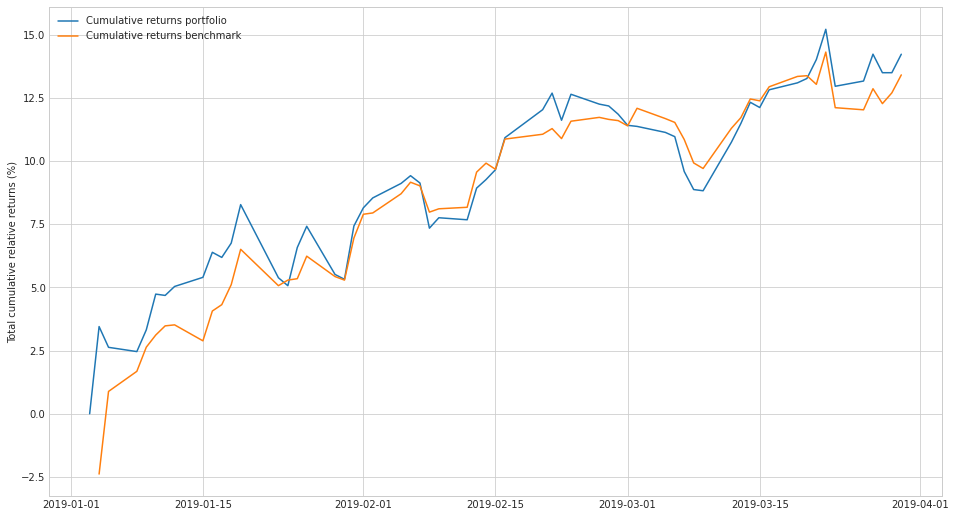

In [176]:
ret2= strategy2_ret.cumsum()
cum_relative_returns2 = np.exp(ret2) - 1
cum_ret2_tot = cum_relative_returns2.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_ret2_tot.index, 100*cum_ret2_tot, label='Cumulative returns portfolio')
ax.plot(cum_ret2_tot.index, 100*benchmark_cum, label='Cumulative returns benchmark')
ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')

In [259]:
#Printing portfolio statistics using the function created above
print_portfolio_yearly_statistics(cum_ret2_tot)

Holding period in days: 61.00
Total portfolio return for the holding period is: 14.23%
Total bechmark return for the holding period is: 13.41%


# Pairs Trading Strategy using Co-integration

## Run OLS Regression 

Aim is to check whether OLS model is a good fit for ETF log prices and to use the regression coefficients to construct the spread series

In [178]:
#https://github.com/QuantConnect/Research/blob/master/Analysis/02%20Kalman%20Filter%20Based%20Pairs%20Trading.ip
#First create pair-combinations
#Then, Run linear regression over two log price series
##Here I'm using ETFs of tech sector (easier to work with a small subset)
results_dict={}
tickers=tickers_all
data=price_all
for i in tickers:
    x = np.log(data[data.columns[tickers.index(i)]])
    x_const = sm.add_constant(x)
    tickers2=[t for t in tickers if t !=i]
    for j in tickers2:
        y = np.log(data[data.columns[tickers.index(j)]])
        linear_reg = sm.OLS(y,x_const)
        results = linear_reg.fit()
        results_dict[(i,j)]=[]
        results_dict[(i,j)].append(results.params[0])
        results_dict[(i,j)].append(results.params[1])

/opt/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [179]:
print (results_dict)

{('XLE', 'IYE'): [-0.4912763344526292, 0.9751470042660195], ('XLE', 'VDE'): [0.4087167860454892, 0.9838286062214974], ('XLE', 'USO'): [-1.611150088324667, 1.5152191730876892], ('XLE', 'XES'): [-1.1954152146074355, 1.4513238040577094], ('XLE', 'XOP'): [2.8117060558684575, 0.47931749747629926], ('XLE', 'UNG'): [5.442676685829601, -0.5499663428214565], ('XLE', 'ICLN'): [-2.961293007021309, 1.280568487818842], ('XLE', 'ERX'): [-5.6989218533900825, 2.7198132889945557], ('XLE', 'ERY'): [16.665342495149638, -3.1815755449525174], ('XLE', 'SCO'): [16.325750824455255, -3.2915508820531136], ('XLE', 'UCO'): [-5.1685279527809715, 2.792450300658176], ('XLE', 'AMJ'): [-0.026264722817002095, 0.7692413143730523], ('XLE', 'BNO'): [-3.1216172681805228, 1.4857448067487107], ('XLE', 'AMLP'): [0.5807878264219282, 0.7788230633476185], ('XLE', 'OIH'): [1.524114676026512, 1.0561139540885232], ('XLE', 'DGAZ'): [6.01997950071898, -0.3588926698516095], ('XLE', 'UGAZ'): [17.6540401701445, -2.9060739105823297], ('X

In [180]:
#Saving results in a dataframe (easier to work with)
results_df=pd.DataFrame.from_dict(results_dict)

In [181]:
results_df.rename(index={0: "alpha", 1:'beta'})

XLE                                                              \
            IYE       VDE       USO       XES       XOP       UNG      ICLN   
alpha -0.491276  0.408717 -1.611150 -1.195415  2.811706  5.442677 -2.961293   
beta   0.975147  0.983829  1.515219  1.451324  0.479317 -0.549966  1.280568   

                                       ...      USMV                       \
            ERX        ERY        SCO  ...      FTEC       SQQQ      TQQQ   
alpha -5.698922  16.665342  16.325751  ... -2.544696  19.936509 -9.040010   
beta   2.719813  -3.181576  -3.291551  ...  1.636350  -3.623830  3.236661   

                                                                                
            TVIX       VIXY      SPLV      SVXY       UVXY      EEMV      EFAV  
alpha  32.248401  17.001026 -0.569281 -2.310467  25.164779  2.411257  2.054934  
beta   -7.180602  -3.425312  1.114087  1.554762  -5.327920  0.405961  0.535664  

[2 rows x 5852 columns]

In [182]:
#The dataframe above has a MultiIndex series for columns. To clearly identify
#dependent vs. independent variable I'm splitting the tickers in two groups x_var is the independent var
#and y_var is the dependent var for each OLS regression. 
x_var=[]
y_var=[]
for i in range(len(results_df.columns)):
    x_var.append(results_df.columns[i][0])
    y_var.append(results_df.columns[i][1])

In [183]:
#Extract the series of y_pred[0] = np.log(data[tickers[0]])*beta + alpha. 
#Plot results to check whether OLS model is a good fit for log prices of ETFs
y_predicted={}
for i in range(len(results_df.columns)):
    y_predicted[(x_var[i],y_var[i])]=[]
    y_predicted[(x_var[i],y_var[i])].append(np.log(data[x_var[i]])*results_df.loc[1][i]+results_df.loc[0][i])

In [184]:
#Save predicted y-values in a dataframe
mycols=list(y_predicted.keys())
y_df=pd.DataFrame(columns=mycols)
for i in range(len(y_predicted.values())):
    colname=mycols[i]
    y_df.loc[:,colname]=pd.DataFrame(list(y_predicted.values())[i]).transpose().iloc[:,0]

y_df.head()

,"(XLE, IYE)","(XLE, VDE)","(XLE, USO)","(XLE, XES)","(XLE, XOP)","(XLE, UNG)","(XLE, ICLN)","(XLE, ERX)","(XLE, ERY)","(XLE, SCO)",...,"(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)","(USMV, EEMV)","(USMV, EFAV)"
2019-01-03,3.362815,4.297121,4.377478,4.540678,4.706121,3.269035,2.099921,5.050646,4.090743,3.316494,...,3.860282,5.752164,3.628884,4.142190,3.593719,3.791462,3.775160,4.310312,4.000262,4.151624
2019-01-04,3.353095,4.287314,4.362376,4.526212,4.701344,3.274516,2.087157,5.023536,4.122455,3.349302,...,3.836161,5.805581,3.581174,4.248035,3.644209,3.775040,3.752242,4.388847,3.994278,4.143728
2019-01-05,3.385722,4.320231,4.413072,4.574771,4.717381,3.256116,2.130003,5.114536,4.016006,3.239173,...,3.871584,5.727134,3.651240,4.092592,3.570060,3.799157,3.785899,4.273511,4.003066,4.155324
2019-01-08,3.400111,4.334749,4.435431,4.596187,4.724454,3.248000,2.148899,5.154670,3.969058,3.190603,...,3.876894,5.715374,3.661744,4.069290,3.558944,3.802773,3.790944,4.256221,4.004384,4.157062
2019-01-09,3.407625,4.342330,4.447106,4.607370,4.728147,3.243762,2.158767,5.175628,3.944542,3.165239,...,3.890868,5.684427,3.689384,4.007969,3.529693,3.812287,3.804221,4.210722,4.007851,4.161637


Text(0, 0.5, 'IYE')

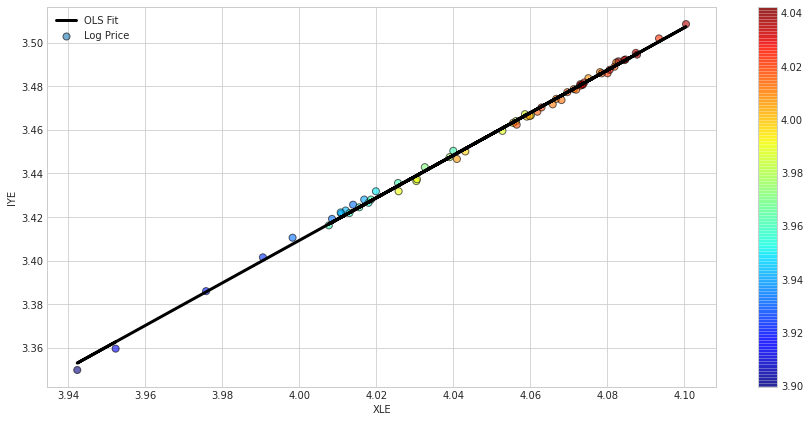

In [185]:
#Plot OLS result - As an example I am plotting the results of the first regression
plt.figure(figsize =(15,7))
x_val=np.log(data[x_var[0]])
y_val=np.log(data[y_var[0]])
y_pred=y_df[y_df.columns[0]]
cm = plt.get_cmap('jet')
sc = plt.scatter(x_val, y_val, s=50, c=x, cmap=cm, marker='o',
                 alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(x_val, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
plt.xlabel(x_var[0])
plt.ylabel(y_var[0])

## Estimate spreads based on the OLS results

Intuition here is that If we have two instruments, X and Y, which are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. 

We'll use the OLS results to construct the spread series

In [186]:
# construct the spread series based on the OLS estimates

mycols=(list(y_predicted.keys()))
spread=pd.DataFrame(columns=mycols)
spread.head()

,"(XLE, IYE)","(XLE, VDE)","(XLE, USO)","(XLE, XES)","(XLE, XOP)","(XLE, UNG)","(XLE, ICLN)","(XLE, ERX)","(XLE, ERY)","(XLE, SCO)",...,"(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)","(USMV, EEMV)","(USMV, EFAV)"


In [187]:
# construct the spread series based on the OLS estimates
for i in range(len(mycols)):
    colname=mycols[i]
    beta=results_df.loc[1][i]
    alpha=results_df.loc[0][i]
    spread.loc[:,colname]=pd.DataFrame(np.log(data[y_var[i]])-np.log(data[x_var[i]])*beta-alpha).iloc[:,0]
spread.head()

,"(XLE, IYE)","(XLE, VDE)","(XLE, USO)","(XLE, XES)","(XLE, XOP)","(XLE, UNG)","(XLE, ICLN)","(XLE, ERX)","(XLE, ERY)","(XLE, SCO)",...,"(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)","(USMV, EEMV)","(USMV, EFAV)"
2019-01-03,-0.003107,-0.003480,-0.010565,-0.048857,-0.052056,-0.070770,-0.000358,-0.004267,-0.000746,0.021764,...,0.017588,0.023819,-0.003402,0.058315,0.029555,-0.003310,-0.014192,0.045371,-0.016604,-0.011747
2019-01-04,-0.003177,-0.003107,0.014639,-0.026836,-0.054265,-0.087751,0.003957,-0.009408,0.000640,-0.030400,...,-0.009425,0.064610,-0.057599,0.039819,0.024977,0.003049,-0.016479,0.033601,-0.022166,-0.005808
2019-01-05,0.000349,0.000074,-0.013205,-0.018953,-0.015381,-0.033646,-0.009035,-0.000784,-0.005639,0.031916,...,-0.001853,0.002329,-0.007298,0.024003,0.015402,-0.000826,-0.009466,0.024319,-0.007994,0.004211
2019-01-08,0.001449,0.001731,-0.024817,0.004347,0.011203,-0.054237,-0.019730,-0.000445,0.001030,0.060934,...,0.004010,-0.018172,0.013580,0.001786,0.005222,-0.003796,-0.004258,0.005755,-0.007539,0.003652
2019-01-09,0.002936,0.002623,-0.016290,-0.004894,0.016587,-0.035341,-0.017997,0.003426,-0.000073,0.042778,...,-0.000313,-0.015827,0.014399,0.021837,0.013294,-0.002601,-0.006936,0.020482,-0.009414,0.001138


Text(0, 0.5, 'spread')

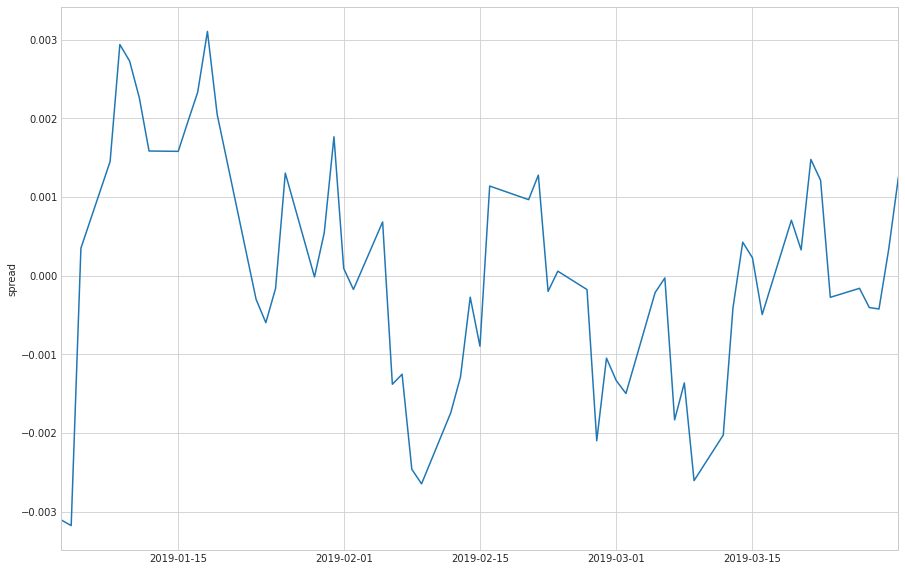

In [188]:
spread[spread.columns[0]].plot(figsize =(15,10))
plt.ylabel('spread')

## Check stationarity of spreads (ADF Test)

ADF tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is stationarity. The more negative this statistic, the more likely we are to reject the null hypothesis (there is a unit root).

As part of the output, we get a table to help determine the ADF statistic. Based on this table we will filter our pairs to select only the ones that exhibit a statistically significant stationary spread. (i.e. select only observations with p-value <0.05, which suggests that we can reject the null hypothesis with a significance level of less than 1%)

Rejecting the null hypothesis with a high degree of confidence, means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. This implies that the pair is highly co-integrated.

In [189]:
#Use pythons stattools pack to run the ADF test and check the stationarity of spreads
#print relevant stats that we'll use later to filter highly co-integrated pairs. 
mycols_adf=spread.columns
adf_df=pd.DataFrame(columns=mycols_adf)
index=["ADF test statistics","ADF 1%", "ADF 5%", "ADF 10%", "p-value"]
for i in range(len(spread.columns)):
    col=mycols_adf[i]
    adf=sm.tsa.stattools.adfuller(spread[spread.columns[i]], maxlag=1)
    adf_df.loc[index[0],col] = adf[0]
    adf_df.loc[index[1],col] = list(adf[4].values())[0]
    adf_df.loc[index[2],col] = list(adf[4].values())[1]
    adf_df.loc[index[3],col] = list(adf[4].values())[2]
    adf_df.loc[index[4],col] = adf[1]
adf_df

,"(XLE, IYE)","(XLE, VDE)","(XLE, USO)","(XLE, XES)","(XLE, XOP)","(XLE, UNG)","(XLE, ICLN)","(XLE, ERX)","(XLE, ERY)","(XLE, SCO)",...,"(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)","(USMV, EEMV)","(USMV, EFAV)"
ADF test statistics,-3.36807,-3.05276,-3.36847,-3.32725,-3.29377,-2.35112,-3.07904,-2.58832,-3.203,-3.49566,...,-4.31261,-4.30557,-4.18095,-3.884,-3.86266,-3.56772,-3.68039,-3.87884,-2.75127,-3.35632
ADF 1%,-3.54437,-3.54437,-3.54437,-3.54437,-3.54639,-3.54437,-3.54437,-3.54437,-3.54437,-3.54437,...,-3.54437,-3.54639,-3.54639,-3.54639,-3.54639,-3.54437,-3.54639,-3.54639,-3.54437,-3.54639
ADF 5%,-2.91107,-2.91107,-2.91107,-2.91107,-2.91194,-2.91107,-2.91107,-2.91107,-2.91107,-2.91107,...,-2.91107,-2.91194,-2.91194,-2.91194,-2.91194,-2.91107,-2.91194,-2.91194,-2.91107,-2.91194
ADF 10%,-2.59319,-2.59319,-2.59319,-2.59319,-2.59365,-2.59319,-2.59319,-2.59319,-2.59319,-2.59319,...,-2.59319,-2.59365,-2.59365,-2.59365,-2.59365,-2.59319,-2.59365,-2.59365,-2.59319,-2.59365
p-value,0.0120969,0.0302522,0.0120819,0.0137036,0.0151594,0.15601,0.0281435,0.0954363,0.0198118,0.00809936,...,0.000422402,0.000434453,0.000709566,0.00215584,0.00232753,0.00640899,0.00439766,0.00219618,0.0655785,0.0125412


In [190]:
#Filter the results where we reject the null hypothesis with a significance level of less than 1%.
#in practical term this means that ADF statistics should be less than ADF 1% and/or
#p-value <0.01

filtered_pairs=list(adf_df.columns[adf_df.loc[adf_df.index[4]]<0.01])
filtered_spread=spread[filtered_pairs]
filtered_spread.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,0.021764,-0.026756,-0.034480,-0.005816,-0.033918,0.052496,0.054349,0.022909,0.161022,0.172411,...,0.019203,-0.023688,0.017588,0.023819,-0.003402,0.058315,0.029555,-0.003310,-0.014192,0.045371
2019-01-04,-0.030400,0.021919,-0.015797,0.023033,-0.020546,0.016449,0.011827,0.007246,0.046160,0.024830,...,-0.016871,-0.034416,-0.009425,0.064610,-0.057599,0.039819,0.024977,0.003049,-0.016479,0.033601
2019-01-05,0.031916,-0.027678,0.003032,-0.001644,0.007816,0.006983,-0.003014,-0.002610,0.016513,-0.015035,...,-0.010215,-0.013955,-0.001853,0.002329,-0.007298,0.024003,0.015402,-0.000826,-0.009466,0.024319
2019-01-08,0.060934,-0.050003,0.010365,-0.018636,0.008956,-0.007414,-0.010725,-0.007033,-0.023392,-0.029206,...,0.002158,0.004679,0.004010,-0.018172,0.013580,0.001786,0.005222,-0.003796,-0.004258,0.005755
2019-01-09,0.042778,-0.029657,0.028016,-0.011803,0.027749,-0.011236,-0.028676,-0.003890,-0.031250,-0.081843,...,-0.017785,-0.006453,-0.000313,-0.015827,0.014399,0.021837,0.013294,-0.002601,-0.006936,0.020482


## Create Trading signals 

Here we use 1.96 times the standard deviation as our threshold. 1.96 is the approximate value of the 97.5 percentile point of the normal distribution. 

95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean. 

If the sample is out of this range, then we think there is a price divergence between these two stocks price which means the pairs trading opportunity.

In [191]:
cols3=filtered_spread.columns
trading_signals=pd.DataFrame(columns=cols3)
index2=["mean spread","upper threshold", "lower_threshold"]
stdev=1.00 #We can impose a more restrictive condition (e.g. 1.96 sd if we want to trade less frequently)
for i in range(len(cols3)):
    trading_signals.loc[index2[0],cols3[i]] = filtered_spread[filtered_spread.columns[i]].mean()
    trading_signals.loc[index2[1],cols3[i]] = filtered_spread[filtered_spread.columns[i]].mean()+stdev*filtered_spread[filtered_spread.columns[i]].std()
    trading_signals.loc[index2[2],cols3[i]] = filtered_spread[filtered_spread.columns[i]].mean()-stdev*filtered_spread[filtered_spread.columns[i]].std()

trading_signals

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
mean spread,1.51427e-15,-1.77053e-14,1.51427e-15,4.94322e-15,-3.14503e-15,-7.28015e-16,7.94992e-15,-2.73734e-15,3.90216e-15,2.21317e-15,...,1.04106e-14,9.5006e-15,-1.51427e-15,-2.85382e-15,6.84334e-15,8.96915e-15,7.04719e-15,2.43885e-15,1.23908e-14,8.44498e-15
upper threshold,0.0369433,0.033453,0.0109798,0.0170538,0.011206,0.0194774,0.0213054,0.0174374,0.0552983,0.0590825,...,0.0141479,0.0221001,0.0075733,0.0249705,0.0240914,0.05196,0.0290308,0.00263192,0.0156296,0.0427044
lower_threshold,-0.0369433,-0.033453,-0.0109798,-0.0170538,-0.011206,-0.0194774,-0.0213054,-0.0174374,-0.0552983,-0.0590825,...,-0.0141479,-0.0221001,-0.0075733,-0.0249705,-0.0240914,-0.05196,-0.0290308,-0.00263192,-0.0156296,-0.0427044


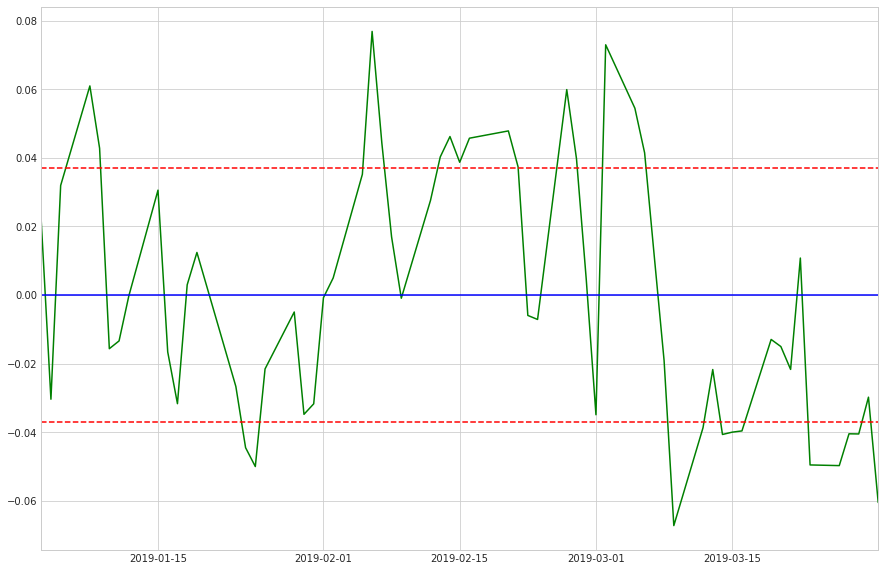

In [192]:
#Plot one example as a reference 
df1=filtered_spread[filtered_spread.columns[0]]
df2=trading_signals[trading_signals.columns[0]]
fig=df1.plot(figsize =(15,10),style=['g', '--r', '--b', '--b'])
fig.axhline(df2[0],c='b')
fig.axhline(df2[1],ls='--',c='r')
fig.axhline(df2[2],ls='--',c='r')

In [193]:
#Here buying the spread means buy 1 unit of independent var(y) and sell
#beta unit of the dependent variable(x).
#We expect that the relationship between x and y will hold in the future. 
#Buying the spread when it is lower than the standard deviation and closing 
#out the position when it returns to mean. 
#Selling the spread means to sell 1 unit of  Y and 
#buy beta units of x when it is above sigma,
#and close the position when reaching the long-term mean to realize a profit.
df_buy=pd.DataFrame(columns=cols3) 
for i in range(len(filtered_spread.columns)):
    c=filtered_spread[filtered_spread.columns[i]]
    df_buy.loc[:,cols3[i]]=((c < trading_signals.iloc[2,i]) & (c.shift(1) > trading_signals.iloc[2,i]) | 
                          (c <  trading_signals.iloc[0,i]) & (c.shift(1) >  trading_signals.iloc[0,i]))
df_buy.head() 

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,True,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,False,False,True,False
2019-01-05,False,True,False,True,False,False,True,True,False,True,...,False,False,False,False,False,False,False,True,False,False
2019-01-08,False,True,False,True,False,True,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False
2019-01-09,False,False,False,False,False,False,True,False,False,True,...,True,True,True,False,False,False,False,False,False,False


In [194]:
df_sell=pd.DataFrame(columns=cols3) 
for i in range(len(filtered_spread.columns)):
    c=filtered_spread[filtered_spread.columns[i]]
    df_sell.loc[:,cols3[i]]=((c > trading_signals.iloc[1,i]) & (c.shift(1) > trading_signals.iloc[1,i]) | 
                          (c >  trading_signals.iloc[0,i]) & (c.shift(1) <  trading_signals.iloc[0,i]))
df_sell.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2019-01-05,True,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-01-08,False,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,False,False,False,False,False
2019-01-09,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [195]:
#Create dataframe with trading signals based on Boolean dataframe above
#buying the spread implied-> buy 1 unit of y-variable (second ticker), 
#sell beta units of x-variable (first ticker)
buyspreadtemp=pd.DataFrame(columns=cols3, index=df_buy.index) 
for i in range(len(df_buy.columns)):
    for j in range(len(df_buy.index)):
        if df_buy.iloc[j,i]==False:
            buyspreadtemp.iloc[j,i]= [0,0]
        else: 
            buyspreadtemp.iloc[j,i]= [-round(results_df.iloc[1,i],0),1] #negative sign denotes sell position

buyspreadtemp.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-04,"[-1.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1]","[0, 0]"
2019-01-05,"[0, 0]","[-1.0, 1]","[0, 0]","[-1.0, 1]","[0, 0]","[0, 0]","[-1.0, 1]","[-3.0, 1]","[0, 0]","[3.0, 1]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1]","[0, 0]","[0, 0]"
2019-01-08,"[0, 0]","[-1.0, 1]","[0, 0]","[-1.0, 1]","[0, 0]","[1.0, 1]","[0, 0]","[0, 0]","[3.0, 1]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[-0.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1]","[0, 0]","[0, 0]"
2019-01-09,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-1.0, 1]","[0, 0]","[0, 0]","[3.0, 1]",...,"[-0.0, 1]","[-0.0, 1]","[-0.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"


In [196]:
buyspread=buyspreadtemp.copy()

In [197]:
#Use the temporary dataframe to create the final dataframe of buy spread trading signals
for j in range(1,len(df_buy.index)):
    for i in range(len(df_buy.columns)):
        if buyspread.iloc[j,i]==[0,0]:
            buyspread.iloc[j,i]=buyspread.iloc[j-1,i]
buyspread.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-04,"[-1.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1]","[0, 0]"
2019-01-05,"[-1.0, 1]","[-1.0, 1]","[0, 0]","[-1.0, 1]","[0, 0]","[0, 0]","[-1.0, 1]","[-3.0, 1]","[0, 0]","[3.0, 1]",...,"[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[-0.0, 1]","[0, 0]","[0, 0]","[0.0, 1]","[0.0, 1]","[0, 0]"
2019-01-08,"[-1.0, 1]","[-1.0, 1]","[0, 0]","[-1.0, 1]","[0, 0]","[1.0, 1]","[-1.0, 1]","[-3.0, 1]","[3.0, 1]","[3.0, 1]",...,"[-0.0, 1]","[0, 0]","[-0.0, 1]","[-0.0, 1]","[-0.0, 1]","[0, 0]","[0, 0]","[0.0, 1]","[0.0, 1]","[0, 0]"
2019-01-09,"[-1.0, 1]","[-1.0, 1]","[0, 0]","[-1.0, 1]","[0, 0]","[1.0, 1]","[-1.0, 1]","[-3.0, 1]","[3.0, 1]","[3.0, 1]",...,"[-0.0, 1]","[-0.0, 1]","[-0.0, 1]","[-0.0, 1]","[-0.0, 1]","[0, 0]","[0, 0]","[0.0, 1]","[0.0, 1]","[0, 0]"


In [198]:
returns_data.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.009967,-0.009790,-0.009433,0.010101,0.007555,-0.006987,-0.011499,-0.008449,-0.032251,0.033098,...,0.094208,-0.101906,0.087349,0.045913,-0.010064,-0.025204,0.066766,-0.011546,-0.001957,-0.014740
2019-01-05,0.033458,0.036152,0.036098,0.022852,0.056441,0.054921,0.035704,0.029853,0.099624,-0.112729,...,-0.140728,0.120367,-0.171258,-0.083725,0.020242,0.040669,-0.124619,0.022961,0.021615,0.021648
2019-01-08,0.014756,0.015490,0.016175,0.010748,0.044717,0.033657,-0.028706,0.008202,0.040473,-0.040279,...,-0.032261,0.031381,-0.045519,-0.021295,0.000646,0.010254,-0.035854,0.001772,0.001179,0.003245
2019-01-09,0.007706,0.009001,0.008473,0.020203,0.001942,0.009077,0.014658,0.011601,0.024829,-0.025618,...,-0.028602,0.028459,-0.041270,-0.021180,0.010709,0.010599,-0.030772,0.001592,0.002060,0.008540


In [199]:
# create datetime index in the returns_data series
returns_data.index=pd.to_datetime(returns_data.index)

In [200]:
buyspreadreturns=pd.DataFrame(columns=buyspread.columns, index=buyspread.index.copy())

In [201]:
returns_data.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.009967,-0.009790,-0.009433,0.010101,0.007555,-0.006987,-0.011499,-0.008449,-0.032251,0.033098,...,0.094208,-0.101906,0.087349,0.045913,-0.010064,-0.025204,0.066766,-0.011546,-0.001957,-0.014740
2019-01-05,0.033458,0.036152,0.036098,0.022852,0.056441,0.054921,0.035704,0.029853,0.099624,-0.112729,...,-0.140728,0.120367,-0.171258,-0.083725,0.020242,0.040669,-0.124619,0.022961,0.021615,0.021648
2019-01-08,0.014756,0.015490,0.016175,0.010748,0.044717,0.033657,-0.028706,0.008202,0.040473,-0.040279,...,-0.032261,0.031381,-0.045519,-0.021295,0.000646,0.010254,-0.035854,0.001772,0.001179,0.003245
2019-01-09,0.007706,0.009001,0.008473,0.020203,0.001942,0.009077,0.014658,0.011601,0.024829,-0.025618,...,-0.028602,0.028459,-0.041270,-0.021180,0.010709,0.010599,-0.030772,0.001592,0.002060,0.008540


In [203]:
# Add returns data for filtered buy spreads
for j in buyspreadreturns.index:
    for i in range(len(buyspreadreturns.columns)):
        firstticker=buyspreadreturns.columns[i][0]
        secondticker=buyspreadreturns.columns[i][1]
        dateindex=buyspreadreturns.index.get_loc(j)
        #dt_ind = j.date()
        element1=round(returns_data.loc[j,firstticker],3)
        element2=round(returns_data.loc[j,secondticker],3)
        buyspreadreturns.iloc[dateindex,i]=[element1, element2] 
buyspreadreturns.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
2019-01-04,"[-0.01, -0.019]","[-0.01, 0.021]","[-0.01, 0.011]","[-0.01, 0.014]","[-0.01, 0.006]","[-0.01, -0.052]","[-0.01, -0.06]","[-0.01, -0.032]","[-0.01, -0.159]","[-0.01, -0.196]",...,"[-0.015, -0.063]","[-0.015, -0.036]","[-0.015, -0.051]","[-0.015, 0.094]","[-0.015, -0.102]","[-0.015, 0.087]","[-0.015, 0.046]","[-0.015, -0.01]","[-0.015, -0.025]","[-0.015, 0.067]"
2019-01-05,"[0.033, -0.048]","[0.033, 0.044]","[0.033, 0.045]","[0.033, 0.025]","[0.033, 0.054]","[0.033, 0.043]","[0.033, 0.044]","[0.033, 0.045]","[0.033, 0.119]","[0.033, 0.122]",...,"[0.022, 0.046]","[0.022, 0.058]","[0.022, 0.043]","[0.022, -0.141]","[0.022, 0.12]","[0.022, -0.171]","[0.022, -0.084]","[0.022, 0.02]","[0.022, 0.041]","[0.022, -0.125]"
2019-01-08,"[0.015, -0.02]","[0.015, 0.019]","[0.015, 0.019]","[0.015, 0.005]","[0.015, 0.013]","[0.015, 0.009]","[0.015, 0.018]","[0.015, 0.02]","[0.015, 0.026]","[0.015, 0.057]",...,"[0.003, 0.018]","[0.003, 0.024]","[0.003, 0.011]","[0.003, -0.032]","[0.003, 0.031]","[0.003, -0.046]","[0.003, -0.021]","[0.003, 0.001]","[0.003, 0.01]","[0.003, -0.036]"
2019-01-09,"[0.008, -0.044]","[0.008, 0.042]","[0.008, 0.024]","[0.008, 0.018]","[0.008, 0.025]","[0.008, 0.008]","[0.008, -0.004]","[0.008, 0.016]","[0.008, 0.026]","[0.008, -0.015]",...,"[0.009, -0.005]","[0.009, 0.004]","[0.009, 0.01]","[0.009, -0.029]","[0.009, 0.028]","[0.009, -0.041]","[0.009, -0.021]","[0.009, 0.011]","[0.009, 0.011]","[0.009, -0.031]"


In [204]:
pair_ret_buy_temp=buyspread.copy()
for i in range(len(pair_ret_buy_temp.columns)):
    for j in range(len(pair_ret_buy_temp.index)):
        pair_ret_buy_temp.iloc[j,i]=np.array(buyspread.iloc[j][i])*np.array(buyspreadreturns.iloc[j][i])
#pair_ret_buy_temp.head()

In [205]:
# Estimate returns for each pair trading on a given day
pair_ret_buy=pair_ret_buy_temp.copy()
for i in range(len(pair_ret_buy_temp.columns)):
    for j in range(len(pair_ret_buy_temp.index)):
        pair_ret_buy.iloc[j,i]=sum(pair_ret_buy_temp.iloc[j][i])
pair_ret_buy.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.009,0,0,0,0,0,0,0,0,0,...,-0.063,0,-0.051,0,-0.102,0,0,0,-0.025,0
2019-01-05,-0.081,0.011,0,-0.008,0,0,0.011,-0.054,0,0.221,...,0.046,0,0.043,0,0.12,0,0,0.02,0.041,0
2019-01-08,-0.035,0.004,0,-0.01,0,0.024,0.003,-0.025,0.071,0.102,...,0.018,0,0.011,-0.032,0.031,0,0,0.001,0.01,0
2019-01-09,-0.052,0.034,0,0.01,0,0.016,-0.012,-0.008,0.05,0.009,...,-0.005,0.004,0.01,-0.029,0.028,0,0,0.011,0.011,0


In [206]:
#Select the pair with the highest cumulative return for each ticker
pair_ret_buy_cum=pair_ret_buy.cumsum()
cumval_buy=pair_ret_buy_cum.iloc[[-1]] #cumulative returns for all filtered pairs 
cumval_buy

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-03-30,-0.645,0.283,-0.087,0.052,0.048,0.296,0.106,-0.198,0.862,1.104,...,0.186,0.183,0.187,-0.432,0.408,-0.767,-0.361,0.151,0.198,-0.571


In [207]:
buyindex=[]
for i in range(len(pair_ret_buy.columns)):
    buyindex.append(pair_ret_buy.columns[i][0])
buyindex_unique=list(set(buyindex))
#buyindex_unique

In [208]:
#Create a function to get index positions for a given value in a df
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [209]:
selectedpairs_buyspread=[]
for i in range(len(buyindex_unique)):
    df2 = cumval_buy.filter(regex=buyindex_unique[i])
    maxval= df2.max().max()
    selected_pair= getIndexes(df2, maxval)[0][1]
    selectedpairs_buyspread.append(selected_pair)
selectedpairs_buyspread=list(set(selectedpairs_buyspread))
#selectedpairs_buyspread

In [210]:
#Create dataframe with trading signals based on Boolean dataframe above.
#Selling the spread implies-> #buy beta units of x-variable
#sell 1 unit of y-variable, 
sellspreadtemp=pd.DataFrame(columns=cols3, index=df_sell.index) 
for i in range(len(df_sell.columns)):
    for j in range(len(df_sell.index)):
        if df_sell.iloc[j,i]==False:
            sellspreadtemp.iloc[j,i]= [0,0]
        else: 
            sellspreadtemp.iloc[j,i]= [round(results_df.iloc[1,i],0),-1]

sellspreadtemp.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-04,"[0, 0]","[1.0, -1]","[0, 0]","[1.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-0.0, -1]","[0, 0]","[0, 0]"
2019-01-05,"[1.0, -1]","[0, 0]","[2.0, -1]","[0, 0]","[0.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-08,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0.0, -1]","[0.0, -1]","[0.0, -1]","[0, 0]","[0.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-09,"[1.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"


In [211]:
#Use the temporary dataframe to create the final dataframe of sell spread trading signals
sellspread=sellspreadtemp.copy()
for j in range(1,len(df_sell.index)):
    for i in range(len(df_sell.columns)):
        if sellspread.iloc[j,i]==[0,0]:
            sellspread.iloc[j,i]=sellspread.iloc[j-1,i]
sellspread.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-04,"[0, 0]","[1.0, -1]","[0, 0]","[1.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-0.0, -1]","[0, 0]","[0, 0]"
2019-01-05,"[1.0, -1]","[1.0, -1]","[2.0, -1]","[1.0, -1]","[0.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-0.0, -1]","[0, 0]","[0, 0]"
2019-01-08,"[1.0, -1]","[1.0, -1]","[2.0, -1]","[1.0, -1]","[0.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0.0, -1]","[0.0, -1]","[0.0, -1]","[0, 0]","[0.0, -1]","[0, 0]","[0, 0]","[-0.0, -1]","[0, 0]","[0, 0]"
2019-01-09,"[1.0, -1]","[1.0, -1]","[2.0, -1]","[1.0, -1]","[0.0, -1]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0.0, -1]","[0.0, -1]","[0.0, -1]","[0, 0]","[0.0, -1]","[0, 0]","[0, 0]","[-0.0, -1]","[0, 0]","[0, 0]"


In [212]:
# Add returns data for filtered sell spreads
sellspreadreturns=pd.DataFrame(columns=sellspread.columns, index=sellspread.index.copy())

In [213]:
# Add returns data for filtered sell spreads
for j in sellspreadreturns.index:
    for i in range(len(sellspreadreturns.columns)):
        firstticker=sellspreadreturns.columns[i][0]
        secondticker=sellspreadreturns.columns[i][1]
        dateindex=sellspreadreturns.index.get_loc(j)
        #dt_ind = j.date()
        element1=round(returns_data.loc[j,firstticker],3)
        element2=round(returns_data.loc[j,secondticker],3)
        sellspreadreturns.iloc[dateindex,i]=[element1, element2] 
sellspreadreturns.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]"
2019-01-04,"[-0.01, -0.019]","[-0.01, 0.021]","[-0.01, 0.011]","[-0.01, 0.014]","[-0.01, 0.006]","[-0.01, -0.052]","[-0.01, -0.06]","[-0.01, -0.032]","[-0.01, -0.159]","[-0.01, -0.196]",...,"[-0.015, -0.063]","[-0.015, -0.036]","[-0.015, -0.051]","[-0.015, 0.094]","[-0.015, -0.102]","[-0.015, 0.087]","[-0.015, 0.046]","[-0.015, -0.01]","[-0.015, -0.025]","[-0.015, 0.067]"
2019-01-05,"[0.033, -0.048]","[0.033, 0.044]","[0.033, 0.045]","[0.033, 0.025]","[0.033, 0.054]","[0.033, 0.043]","[0.033, 0.044]","[0.033, 0.045]","[0.033, 0.119]","[0.033, 0.122]",...,"[0.022, 0.046]","[0.022, 0.058]","[0.022, 0.043]","[0.022, -0.141]","[0.022, 0.12]","[0.022, -0.171]","[0.022, -0.084]","[0.022, 0.02]","[0.022, 0.041]","[0.022, -0.125]"
2019-01-08,"[0.015, -0.02]","[0.015, 0.019]","[0.015, 0.019]","[0.015, 0.005]","[0.015, 0.013]","[0.015, 0.009]","[0.015, 0.018]","[0.015, 0.02]","[0.015, 0.026]","[0.015, 0.057]",...,"[0.003, 0.018]","[0.003, 0.024]","[0.003, 0.011]","[0.003, -0.032]","[0.003, 0.031]","[0.003, -0.046]","[0.003, -0.021]","[0.003, 0.001]","[0.003, 0.01]","[0.003, -0.036]"
2019-01-09,"[0.008, -0.044]","[0.008, 0.042]","[0.008, 0.024]","[0.008, 0.018]","[0.008, 0.025]","[0.008, 0.008]","[0.008, -0.004]","[0.008, 0.016]","[0.008, 0.026]","[0.008, -0.015]",...,"[0.009, -0.005]","[0.009, 0.004]","[0.009, 0.01]","[0.009, -0.029]","[0.009, 0.028]","[0.009, -0.041]","[0.009, -0.021]","[0.009, 0.011]","[0.009, 0.011]","[0.009, -0.031]"


In [214]:
pair_ret_sell_temp=sellspread.copy()
for i in range(len(pair_ret_sell_temp.columns)):
    for j in range(len(pair_ret_sell_temp.index)):
        pair_ret_sell_temp.iloc[j,i]=np.array(sellspread.iloc[j][i])*np.array(sellspreadreturns.iloc[j][i])
#pair_ret_sell_temp.head()

In [215]:
# Estimate returns for each pair trading on a given day
pair_ret_sell=pair_ret_sell_temp.copy()
for i in range(len(pair_ret_sell_temp.columns)):
    for j in range(len(pair_ret_sell_temp.index)):
        pair_ret_sell.iloc[j,i]=sum(pair_ret_sell_temp.iloc[j][i])
pair_ret_sell.head()

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,0,-0.031,0,-0.024,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.01,0,0
2019-01-05,0.081,-0.011,0.021,0.008,-0.054,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.02,0,0
2019-01-08,0.035,-0.004,0.011,0.01,-0.013,0,0,0,0,0,...,-0.018,-0.024,-0.011,0,-0.031,0,0,-0.001,0,0
2019-01-09,0.052,-0.034,-0.008,-0.01,-0.025,0,0,0,0,0,...,0.005,-0.004,-0.01,0,-0.028,0,0,-0.011,0,0


In [216]:
#Select the pair with the highest cumulative return for each ticker
pair_ret_sell_cum=pair_ret_sell.cumsum()
cumval_sell=pair_ret_sell_cum.iloc[[-1]] #cumulative returns for all filtered pairs
cumval_sell

,"(XLE, SCO)","(XLE, UCO)","(XLE, AMJ)","(XLE, BNO)","(XLE, AMLP)","(XLE, XLK)","(XLE, SOXX)","(XLE, IGV)","(XLE, TECL)","(XLE, SOXL)",...,"(USMV, SMH)","(USMV, KWEB)","(USMV, FTEC)","(USMV, SQQQ)","(USMV, TQQQ)","(USMV, TVIX)","(USMV, VIXY)","(USMV, SPLV)","(USMV, SVXY)","(USMV, UVXY)"
2019-03-30,0.636,-0.314,0.155,-0.076,-0.135,-0.209,-0.093,0.073,-0.607,-0.684,...,-0.203,-0.207,-0.195,0.265,-0.39,0.723,0.338,-0.141,-0.161,0.537


In [217]:
sellindex=[]
for i in range(len(pair_ret_sell.columns)):
    sellindex.append(pair_ret_sell.columns[i][0])
sellindex_unique=list(set(sellindex))
#sellindex_unique

In [218]:
selectedpairs_sellspread=[]
for i in range(len(sellindex_unique)):
    df2 = cumval_sell.filter(regex=sellindex_unique[i])
    maxval= df2.max().max()
    selected_pair= getIndexes(df2, maxval)[0][1]
    selectedpairs_sellspread.append(selected_pair)
selectedpairs_sellspread=list(set(selectedpairs_sellspread))
# selectedpairs_sellspread

In [219]:
#There may be an intersection between the pairs selected as a result of the buy spread strategy and the
#pairs selected from the sell spread strategy. We'll find the common pairs and 
#apply the strategy (either sell/buy spread) that generates the highest cumulative return

def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

commonelements=list(common_elements(selectedpairs_buyspread,selectedpairs_sellspread))
len(commonelements)

0

In [220]:
for i in range(len(commonelements)):
    el= commonelements[i]
    if np.array(cumval_sell[el]>cumval_buy[el])==True:
        selectedpairs_buyspread.remove(el)
    else: 
        selectedpairs_sellspread.remove(el)

In [221]:
totalselectedpairs=selectedpairs_buyspread+selectedpairs_sellspread
# totalselectedpairs
#Assuming an equal portfolio allocation for each pair we can assing the following weights:
weight_buyspread=len(selectedpairs_buyspread)/len(totalselectedpairs)
weight_sellspread=len(selectedpairs_sellspread)/len(totalselectedpairs)
weight_buyspread+weight_sellspread


1.0

## Portfolio 3 - Returns

In [222]:
df_1=pair_ret_buy[selectedpairs_buyspread]
df_2=pair_ret_sell[selectedpairs_sellspread]

In [223]:
df_1=df_1*(weight_buyspread/len(selectedpairs_buyspread))
df_2=df_2*(weight_sellspread/len(selectedpairs_sellspread))

df_2.head()

,"(SQQQ, VGT)","(FXL, AMJ)","(IAU, XOP)","(VGSH, SCO)","(JDST, XES)","(EDV, SOXS)","(GDXJ, OIH)","(AGQ, USLV)","(SHY, SCO)","(SOXS, XES)",...,"(UCO, XLK)","(SVXY, ERY)","(PPLT, XOP)","(DUST, AMJ)","(SCHO, SOXS)","(UVXY, SMH)","(SOXL, EEMV)","(ERY, SCO)","(IEI, TECS)","(UNG, IGV)"
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,-0.00251938,0,0,0.000147287,0,-0.00124806,0,0,0.000147287,0,...,0,-0.000255814,0,0,-0.00123256,0,0,0,-0.00118605,0
2019-01-05,0.00403876,0,0,0.000372093,0,0.00108527,0,7.75194e-06,0.000372093,0,...,0.000689922,0.000875969,0,0,0.00106202,0,0,0.003,0.00118605,0
2019-01-08,0.000906977,0.000162791,0,0.000155039,0,0.00044186,0,0,0.000155039,0.0014186,...,0.000372093,0.000310078,0,0,0.00044186,0.000976744,0,0.00108527,0.000248062,0
2019-01-09,0.000821705,-1.55039e-05,-3.87597e-05,0.000341085,0,-0.000100775,0,2.32558e-05,0.000341085,-0.000418605,...,0.000914729,0.00020155,0,-0.000108527,-0.000108527,0.001,0,0.000945736,0.00024031,0


In [224]:
#ret3_buyspread.astype(float)

Total portfolio return from buy spread is: 2019-03-30    44.989129
dtype: float64%
Total portfolio return from sell spread is: 2019-03-30    48.859539
dtype: float64%
Total portfolio return from pairs trading strategy is: 2019-03-30    93.848668
dtype: float64%


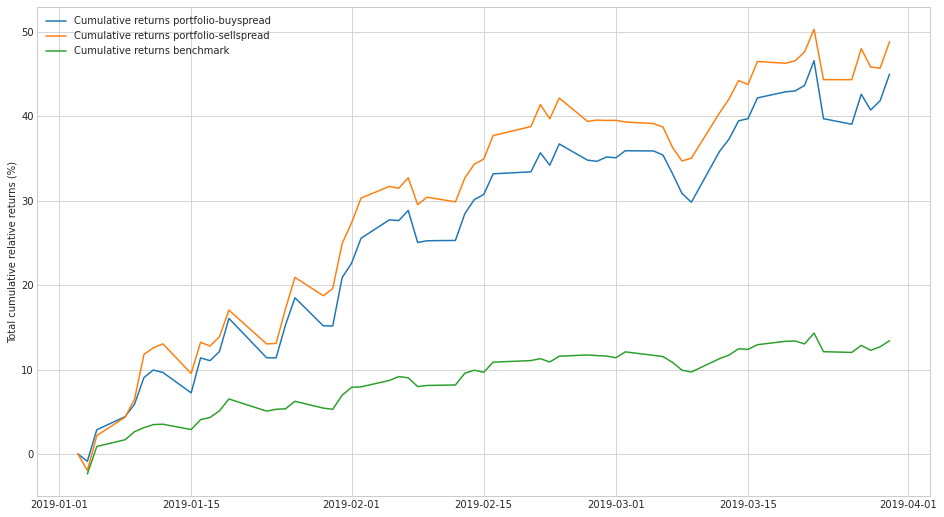

In [260]:
ret3_buyspread= df_1.cumsum().astype(float)
cum_relative_returns3_buyspread = np.exp(ret3_buyspread) - 1
cum_ret3_tot_buyspread = cum_relative_returns3_buyspread.sum(axis=1)
ret3_sellspread= df_2.cumsum().astype(float)
cum_relative_returns3_sellspread = np.exp(ret3_sellspread) - 1
cum_ret3_tot_sellspread = cum_relative_returns3_sellspread.sum(axis=1)

total_cumret_pairstrading=cum_ret3_tot_buyspread +cum_ret3_tot_sellspread

print('Total portfolio return from buy spread is: ' + str(100*cum_ret3_tot_buyspread [[-1]])+ '%')
print('Total portfolio return from sell spread is: ' + str(100*cum_ret3_tot_sellspread[[-1]]) + '%')
print('Total portfolio return from pairs trading strategy is: ' + str(100*total_cumret_pairstrading[[-1]]) + '%')


fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_ret3_tot_buyspread.index, 100*cum_ret3_tot_buyspread, label='Cumulative returns portfolio-buyspread')
ax.plot(cum_ret3_tot_sellspread.index, 100*cum_ret3_tot_sellspread, label='Cumulative returns portfolio-sellspread')
ax.plot(cum_ret2_tot.index, 100*benchmark_cum, label='Cumulative returns benchmark')
ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')

In [261]:
#Printing portfolio statistics for our pairs trading strategy
print_portfolio_yearly_statistics(total_cumret_pairstrading)

Holding period in days: 61.00
Total portfolio return for the holding period is: 93.85%
Total bechmark return for the holding period is: 13.41%


# Final Portfolio: Combination of Pairs Trading with momentum indicators 

This algorithm simultaneously checks whether:
  i. the instrument for which pairs trading strategy has indicated a buy signal, has a positive momentum -> if so, final insight is a buy 
 ii. the instrument for which pairs trading strategy has indicated a sell signal, has a negative momentum -> if so, final insight is a sell

If both conditions are met, pairs trading is executed 

In [227]:
#selectedpairs_buyspread

[('USO', 'TECS'),
 ('SMH', 'BNO'),
 ('TMV', 'TECL'),
 ('UGAZ', 'XES'),
 ('UNG', 'AMJ'),
 ('TAN', 'XES'),
 ('SPTL', 'TQQQ'),
 ('SHV', 'UCO'),
 ('JDST', 'AMLP'),
 ('USO', 'ERX'),
 ('SCO', 'AMLP'),
 ('UGLD', 'AMJ'),
 ('SQQQ', 'SOXX'),
 ('UCO', 'VGT'),
 ('TLH', 'TECL'),
 ('SOXL', 'BNO'),
 ('SOXS', 'VDE'),
 ('SOXS', 'USMV'),
 ('BIL', 'AMLP'),
 ('VGSH', 'UCO'),
 ('JNUG', 'AMJ'),
 ('VIXY', 'TECL'),
 ('TQQQ', 'VGT'),
 ('TBT', 'SOXL'),
 ('GOVT', 'TECL'),
 ('SCHO', 'TECL'),
 ('ICLN', 'KWEB'),
 ('SCHR', 'UCO'),
 ('DUST', 'ERX'),
 ('SCO', 'ERY'),
 ('VIXY', 'FTEC'),
 ('SQQQ', 'XLK'),
 ('IEF', 'TECL'),
 ('USO', 'TQQQ'),
 ('AGQ', 'AMJ'),
 ('EEMV', 'XOP'),
 ('USLV', 'XES'),
 ('VGLT', 'TECL'),
 ('DGAZ', 'FXL'),
 ('PPLT', 'XES'),
 ('TVIX', 'IYE'),
 ('IEI', 'TECL'),
 ('TQQQ', 'TECL'),
 ('TMF', 'SOXL'),
 ('UCO', 'EFAV'),
 ('VIXY', 'FDN'),
 ('GDXJ', 'XES'),
 ('VIXY', 'SKYY'),
 ('TLT', 'TECL'),
 ('VGIT', 'UCO'),
 ('SCO', 'XLE'),
 ('SPTS', 'TECL'),
 ('UVXY', 'TECL'),
 ('KWEB', 'SVXY'),
 ('NUGT', 'KWEB'),
 ('

In [228]:
# #Create a df that will help us locate the first non-zero index of the buy spread series.
# #This will help us locate the corresponding price momentum value for each symbol
# dfbuy_temp=df_buy.copy()
# for i in range(len(df_buy.columns)):
#     for j in range(len(df_buy.index)):
#         if df_buy.iloc[j,i]==False:
#             dfbuy_temp.iloc[j,i]= 0
#         else: 
#             dfbuy_temp.iloc[j,i]= 1

# dfbuy_temp.head()

In [229]:
#Locate first non-zero value for each column
# m = dfbuy_temp.ne(0).idxmax()
# df_firstnonzero=pd.DataFrame(dict(pos=m, val=dfbuy_temp.lookup(m, m.index)))
# df_firstnonzero


In [230]:
#Momentum indicator summary genereated from price vs. short EMA comparison
momindicator=trading_positions_raw.apply(np.sign)
momindicator.head()

,XLE,IYE,VDE,USO,XES,XOP,UNG,ICLN,ERX,ERY,...,SQQQ,TQQQ,TVIX,VIXY,SPLV,SVXY,UVXY,EEMV,EFAV,USMV
2019-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2019-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2019-01-08,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2019-01-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0


In [231]:
#Here we're filtering the positions for our selected pairs based on the buyspread strategy
#As a final insight we want to invest only in pairs that have consisten signals from both strategies 
# df1_positions=buyspread[selectedpairs_buyspread]
# df1_positions.head()

In [232]:
#Find average momentum indicator for each symbol and check its consistency
#with the signal obtained from buy-spread pairs trading strategy 
final_list_pairs_buyspread=[]
for i in range(len(selectedpairs_buyspread)):
    pair=selectedpairs_buyspread[i]
    symbol_1=selectedpairs_buyspread[i][0]
    symbol_2= selectedpairs_buyspread[i][1]
#     Estimate average sentiment for each symbol in our pair
    avgmomfreq1=momindicator[symbol_1].mean()
    avgmomfreq2=momindicator[symbol_2].mean()
    if (avgmomfreq1<0 and avgmomfreq2>0):
        final_list_pairs_buyspread.append(pair)
            
#final_list_pairs_buyspread

[('TMV', 'TECL'),
 ('UGAZ', 'XES'),
 ('JDST', 'AMLP'),
 ('SCO', 'AMLP'),
 ('SQQQ', 'SOXX'),
 ('SOXS', 'VDE'),
 ('SOXS', 'USMV'),
 ('VIXY', 'TECL'),
 ('TBT', 'SOXL'),
 ('DUST', 'ERX'),
 ('VIXY', 'FTEC'),
 ('SQQQ', 'XLK'),
 ('AGQ', 'AMJ'),
 ('USLV', 'XES'),
 ('DGAZ', 'FXL'),
 ('TVIX', 'IYE'),
 ('VIXY', 'FDN'),
 ('VIXY', 'SKYY'),
 ('SCO', 'XLE'),
 ('UVXY', 'TECL'),
 ('VIXY', 'SPLV'),
 ('SLV', 'XES'),
 ('VIXY', 'IGV'),
 ('TVIX', 'AMJ'),
 ('TVIX', 'UCO'),
 ('VIXY', 'KWEB')]

In [233]:
selectedpairs_sellspread

[('SQQQ', 'VGT'),
 ('FXL', 'AMJ'),
 ('IAU', 'XOP'),
 ('VGSH', 'SCO'),
 ('JDST', 'XES'),
 ('EDV', 'SOXS'),
 ('GDXJ', 'OIH'),
 ('AGQ', 'USLV'),
 ('SHY', 'SCO'),
 ('SOXS', 'XES'),
 ('GOVT', 'SCO'),
 ('FDN', 'TVIX'),
 ('JNUG', 'OIH'),
 ('SPTL', 'SOXS'),
 ('VGLT', 'SOXS'),
 ('UGAZ', 'NUGT'),
 ('SKYY', 'TVIX'),
 ('TVIX', 'XLK'),
 ('ERX', 'UVXY'),
 ('AMLP', 'SCO'),
 ('TBT', 'SOXS'),
 ('SPLV', 'TECS'),
 ('GDX', 'XOP'),
 ('SCO', 'FTEC'),
 ('TLH', 'TECS'),
 ('GLD', 'XOP'),
 ('KWEB', 'ICLN'),
 ('VIXY', 'USMV'),
 ('VIXY', 'SMH'),
 ('QTEC', 'SOXS'),
 ('TQQQ', 'TECS'),
 ('TAN', 'XOP'),
 ('TVIX', 'SOXX'),
 ('IGV', 'VIXY'),
 ('BNO', 'TVIX'),
 ('TMV', 'SOXS'),
 ('SCO', 'EFAV'),
 ('TVIX', 'XLE'),
 ('VGIT', 'SCO'),
 ('DUST', 'ICLN'),
 ('VDE', 'UVXY'),
 ('SCO', 'AMJ'),
 ('SCO', 'TECL'),
 ('SOXS', 'USO'),
 ('BIL', 'SHV'),
 ('DGAZ', 'OIH'),
 ('SCHR', 'TECS'),
 ('TLT', 'SOXS'),
 ('UGLD', 'XOP'),
 ('SPTS', 'SOXS'),
 ('SCO', 'SOXL'),
 ('IEF', 'TECS'),
 ('TMF', 'TECS'),
 ('SMH', 'IYE'),
 ('UCO', 'XLK'),
 ('SVXY

In [234]:
#Find average momentum indicator for each symbol and check its consistency
#with the signal obtained from sell-spread pairs trading strategy 
final_list_pairs_sellspread=[]
for i in range(len(selectedpairs_sellspread)):
    pair=selectedpairs_sellspread[i]
    symbol_1=selectedpairs_sellspread[i][0]
    symbol_2= selectedpairs_sellspread[i][1]
#     Estimate average sentiment for each symbol in our pair
    avgmomfreq1=momindicator[symbol_1].mean()
    avgmomfreq2=momindicator[symbol_2].mean()
    if (avgmomfreq1>0 and avgmomfreq2<0):
        final_list_pairs_sellspread.append(pair)
            
#final_list_pairs_sellspread

[('VGSH', 'SCO'),
 ('EDV', 'SOXS'),
 ('SHY', 'SCO'),
 ('GOVT', 'SCO'),
 ('FDN', 'TVIX'),
 ('SPTL', 'SOXS'),
 ('VGLT', 'SOXS'),
 ('SKYY', 'TVIX'),
 ('ERX', 'UVXY'),
 ('AMLP', 'SCO'),
 ('SPLV', 'TECS'),
 ('TLH', 'TECS'),
 ('QTEC', 'SOXS'),
 ('TQQQ', 'TECS'),
 ('IGV', 'VIXY'),
 ('BNO', 'TVIX'),
 ('VGIT', 'SCO'),
 ('VDE', 'UVXY'),
 ('SCHR', 'TECS'),
 ('TLT', 'SOXS'),
 ('SPTS', 'SOXS'),
 ('IEF', 'TECS'),
 ('TMF', 'TECS'),
 ('SVXY', 'ERY'),
 ('SCHO', 'SOXS'),
 ('IEI', 'TECS')]

In [235]:
final_list_pairstrading=final_list_pairs_buyspread+final_list_pairs_sellspread
final_list_pairstrading

[('TMV', 'TECL'),
 ('UGAZ', 'XES'),
 ('JDST', 'AMLP'),
 ('SCO', 'AMLP'),
 ('SQQQ', 'SOXX'),
 ('SOXS', 'VDE'),
 ('SOXS', 'USMV'),
 ('VIXY', 'TECL'),
 ('TBT', 'SOXL'),
 ('DUST', 'ERX'),
 ('VIXY', 'FTEC'),
 ('SQQQ', 'XLK'),
 ('AGQ', 'AMJ'),
 ('USLV', 'XES'),
 ('DGAZ', 'FXL'),
 ('TVIX', 'IYE'),
 ('VIXY', 'FDN'),
 ('VIXY', 'SKYY'),
 ('SCO', 'XLE'),
 ('UVXY', 'TECL'),
 ('VIXY', 'SPLV'),
 ('SLV', 'XES'),
 ('VIXY', 'IGV'),
 ('TVIX', 'AMJ'),
 ('TVIX', 'UCO'),
 ('VIXY', 'KWEB'),
 ('VGSH', 'SCO'),
 ('EDV', 'SOXS'),
 ('SHY', 'SCO'),
 ('GOVT', 'SCO'),
 ('FDN', 'TVIX'),
 ('SPTL', 'SOXS'),
 ('VGLT', 'SOXS'),
 ('SKYY', 'TVIX'),
 ('ERX', 'UVXY'),
 ('AMLP', 'SCO'),
 ('SPLV', 'TECS'),
 ('TLH', 'TECS'),
 ('QTEC', 'SOXS'),
 ('TQQQ', 'TECS'),
 ('IGV', 'VIXY'),
 ('BNO', 'TVIX'),
 ('VGIT', 'SCO'),
 ('VDE', 'UVXY'),
 ('SCHR', 'TECS'),
 ('TLT', 'SOXS'),
 ('SPTS', 'SOXS'),
 ('IEF', 'TECS'),
 ('TMF', 'TECS'),
 ('SVXY', 'ERY'),
 ('SCHO', 'SOXS'),
 ('IEI', 'TECS')]

In [236]:
#Trading positions for our final list of insights
buyspread[final_list_pairs_buyspread].head()
sellspread[final_list_pairs_sellspread].head()
pd.concat([buyspread[final_list_pairs_buyspread], sellspread[final_list_pairs_sellspread]],axis=1).head()

,"(TMV, TECL)","(UGAZ, XES)","(JDST, AMLP)","(SCO, AMLP)","(SQQQ, SOXX)","(SOXS, VDE)","(SOXS, USMV)","(VIXY, TECL)","(TBT, SOXL)","(DUST, ERX)",...,"(VGIT, SCO)","(VDE, UVXY)","(SCHR, TECS)","(TLT, SOXS)","(SPTS, SOXS)","(IEF, TECS)","(TMF, TECS)","(SVXY, ERY)","(SCHO, SOXS)","(IEI, TECS)"
2019-01-03,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
2019-01-04,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-5.0, 1]","[0, 0]","[0, 0]",...,"[1.0, -1]","[0, 0]","[-0.0, -1]","[0.0, -1]","[0.0, -1]","[1.0, -1]","[-0.0, -1]","[0.0, -1]","[1.0, -1]","[-2.0, -1]"
2019-01-05,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-3.0, 1]","[0, 0]","[0, 0]","[-5.0, 1]","[0, 0]","[0, 0]",...,"[1.0, -1]","[2.0, -1]","[-0.0, -1]","[0.0, -1]","[0.0, -1]","[1.0, -1]","[-0.0, -1]","[0.0, -1]","[1.0, -1]","[-2.0, -1]"
2019-01-08,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-3.0, 1]","[0, 0]","[-2.0, 1]","[-5.0, 1]","[0, 0]","[0, 0]",...,"[1.0, -1]","[2.0, -1]","[-0.0, -1]","[0.0, -1]","[0.0, -1]","[1.0, -1]","[-0.0, -1]","[0.0, -1]","[1.0, -1]","[-2.0, -1]"
2019-01-09,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[-3.0, 1]","[0, 0]","[-2.0, 1]","[-5.0, 1]","[0, 0]","[0, 0]",...,"[1.0, -1]","[2.0, -1]","[-0.0, -1]","[0.0, -1]","[0.0, -1]","[1.0, -1]","[-0.0, -1]","[0.0, -1]","[1.0, -1]","[-2.0, -1]"


## Calculating returns - Final portfolio

In [237]:
final_list_pairstrading

[('TMV', 'TECL'),
 ('UGAZ', 'XES'),
 ('JDST', 'AMLP'),
 ('SCO', 'AMLP'),
 ('SQQQ', 'SOXX'),
 ('SOXS', 'VDE'),
 ('SOXS', 'USMV'),
 ('VIXY', 'TECL'),
 ('TBT', 'SOXL'),
 ('DUST', 'ERX'),
 ('VIXY', 'FTEC'),
 ('SQQQ', 'XLK'),
 ('AGQ', 'AMJ'),
 ('USLV', 'XES'),
 ('DGAZ', 'FXL'),
 ('TVIX', 'IYE'),
 ('VIXY', 'FDN'),
 ('VIXY', 'SKYY'),
 ('SCO', 'XLE'),
 ('UVXY', 'TECL'),
 ('VIXY', 'SPLV'),
 ('SLV', 'XES'),
 ('VIXY', 'IGV'),
 ('TVIX', 'AMJ'),
 ('TVIX', 'UCO'),
 ('VIXY', 'KWEB'),
 ('VGSH', 'SCO'),
 ('EDV', 'SOXS'),
 ('SHY', 'SCO'),
 ('GOVT', 'SCO'),
 ('FDN', 'TVIX'),
 ('SPTL', 'SOXS'),
 ('VGLT', 'SOXS'),
 ('SKYY', 'TVIX'),
 ('ERX', 'UVXY'),
 ('AMLP', 'SCO'),
 ('SPLV', 'TECS'),
 ('TLH', 'TECS'),
 ('QTEC', 'SOXS'),
 ('TQQQ', 'TECS'),
 ('IGV', 'VIXY'),
 ('BNO', 'TVIX'),
 ('VGIT', 'SCO'),
 ('VDE', 'UVXY'),
 ('SCHR', 'TECS'),
 ('TLT', 'SOXS'),
 ('SPTS', 'SOXS'),
 ('IEF', 'TECS'),
 ('TMF', 'TECS'),
 ('SVXY', 'ERY'),
 ('SCHO', 'SOXS'),
 ('IEI', 'TECS')]

In [238]:
#Identify daily returns for each pair based on the buy-spread and sell-spread strategy
pair_ret_buyfinal=pair_ret_buy[final_list_pairs_buyspread]
pair_ret_sellfinal=pair_ret_sell[final_list_pairs_sellspread]


In [239]:
#Assuming an equal portfolio allocation for each pair we can assing the following weights:
weight_buyspread_final=len(final_list_pairs_buyspread)/len(final_list_pairstrading)
weight_sellspread_final=len(final_list_pairs_sellspread)/len(final_list_pairstrading)
weight_buyspread_final+weight_sellspread_final


1.0

In [240]:
pair_ret_buyfinal=pair_ret_buyfinal*(weight_buyspread_final/len(final_list_pairs_buyspread))
pair_ret_sellfinal=pair_ret_sellfinal*(weight_sellspread_final/len(final_list_pairs_sellspread))

pd.concat([pair_ret_buyfinal, pair_ret_sellfinal],axis=1).head()

,"(TMV, TECL)","(UGAZ, XES)","(JDST, AMLP)","(SCO, AMLP)","(SQQQ, SOXX)","(SOXS, VDE)","(SOXS, USMV)","(VIXY, TECL)","(TBT, SOXL)","(DUST, ERX)",...,"(VGIT, SCO)","(VDE, UVXY)","(SCHR, TECS)","(TLT, SOXS)","(SPTS, SOXS)","(IEF, TECS)","(TMF, TECS)","(SVXY, ERY)","(SCHO, SOXS)","(IEI, TECS)"
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,0,0,0,0,0,0,0,-0.00748077,0,0,...,0.0005,0,-0.00271154,-0.00309615,-0.00309615,-0.00255769,-0.00271154,-0.000634615,-0.00305769,-0.00294231
2019-01-05,0,0,0,0,0.00898077,0,0,0.0103654,0,0,...,0.000807692,0.00378846,0.00271154,0.00269231,0.00269231,0.00255769,0.00271154,0.00217308,0.00263462,0.00294231
2019-01-08,0,0,0,0,0.00219231,0,0.00225,0.00251923,0,0,...,0.000326923,0.00130769,0.000538462,0.00109615,0.00109615,0.000480769,0.000538462,0.000769231,0.00109615,0.000615385
2019-01-09,0,0,0,0,0.00159615,0,-0.000326923,0.00251923,0,0,...,0.000807692,0.000903846,0.000519231,-0.00025,-0.00025,0.000461538,0.000519231,0.0005,-0.000269231,0.000596154


Total portfolio return from buy spread is: 2019-03-30    61.029943
dtype: float64%
Total portfolio return from sell spread is: 2019-03-30    37.707791
dtype: float64%
Total portfolio return from pairs trading strategy is: 2019-03-30    98.737734
dtype: float64%


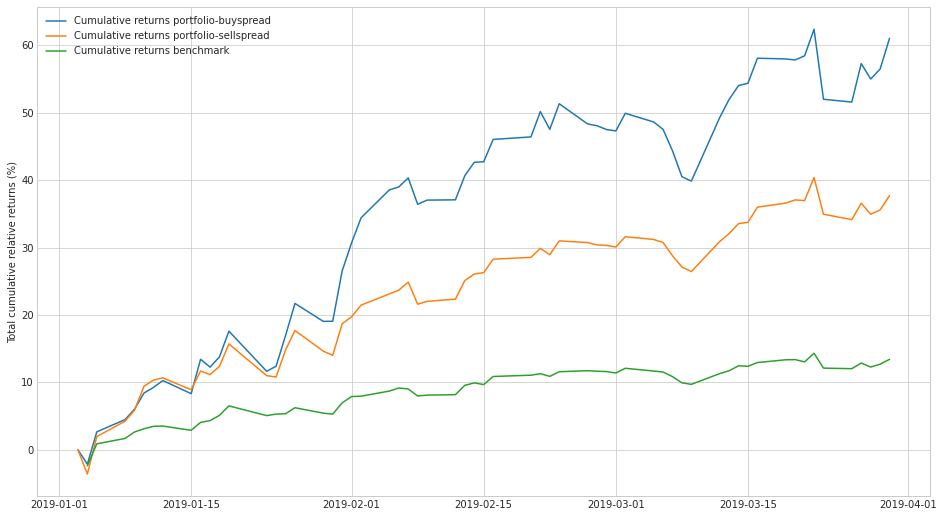

In [262]:
ret4_buyspread= pair_ret_buyfinal.cumsum().astype(float)
cum_relative_returns4_buyspread = np.exp(ret4_buyspread) - 1
cum_ret4_tot_buyspread = cum_relative_returns4_buyspread.sum(axis=1)
ret4_sellspread= pair_ret_sellfinal.cumsum().astype(float)
cum_relative_returns4_sellspread = np.exp(ret4_sellspread) - 1
cum_ret4_tot_sellspread = cum_relative_returns4_sellspread.sum(axis=1)

total_cumret4=cum_ret4_tot_buyspread +cum_ret4_tot_sellspread

print('Total portfolio return from buy spread is: ' + str(100*cum_ret4_tot_buyspread [[-1]])+ '%')
print('Total portfolio return from sell spread is: ' + str(100*cum_ret4_tot_sellspread[[-1]]) + '%')
print('Total portfolio return from pairs trading strategy is: ' + str(100*total_cumret4[[-1]]) + '%')


fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_ret4_tot_buyspread.index, 100*cum_ret4_tot_buyspread, label='Cumulative returns portfolio-buyspread')
ax.plot(cum_ret4_tot_sellspread.index, 100*cum_ret4_tot_sellspread, label='Cumulative returns portfolio-sellspread')
ax.plot(cum_ret2_tot.index, 100*benchmark_cum, label='Cumulative returns benchmark')
ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')

In [263]:
#Printing portfolio statistics for our pairs trading strategy
print_portfolio_yearly_statistics(total_cumret4)

Holding period in days: 61.00
Total portfolio return for the holding period is: 98.74%
Total bechmark return for the holding period is: 13.41%
